In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

In [32]:
df_train = pd.read_csv("C:/Users/Utente/OneDrive/Desktop/UNIPI - DS for Business Informatics/Data Mining_2/Progetto/df_train_processed.csv")

In [33]:
def get_top_scores(decision_scores, percentage, higher_is_outlier=True, show_index=False):
    """Returns the top scores (in the percentage indicated). If show_index = True,
    returns only the correspondent indexes. If higher_is_outlier=False, then lower the score, higher the
    outlierness"""
    n_items = int(np.ceil((percentage * len(decision_scores)) / 100))
    dic = {}
    for index, score in enumerate(decision_scores):
        dic[score] = index
    if higher_is_outlier:
        top_scores = sorted(decision_scores, reverse=True)[:n_items]
    else:
        top_scores = sorted(decision_scores)[:n_items]
    if show_index == True:
        return [dic[score] for score in top_scores]
    return top_scores

In [34]:
df_train.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,frame_count,sum,mean,...,stft_std_w4,stft_min_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,speech,neutral,normal,Kids are talking by the door,1st,1,M,158558,0.145081,9.150000e-07,...,0.155455,0.000000,0.000000,0.566462,0.709962,0.799141,0.896606,1.0,6.742190,-1.706215
1,speech,neutral,normal,Kids are talking by the door,2nd,1,M,160160,0.114319,7.137790e-07,...,0.163183,0.270133,0.368623,0.472736,0.623183,0.744908,0.874713,1.0,-0.700420,-0.201495
2,speech,neutral,normal,Dogs are sitting by the door,1st,1,M,156956,0.149963,9.554485e-07,...,0.190634,0.000000,0.000000,0.417919,0.643636,0.774253,0.899156,1.0,1.688986,-1.024773
3,speech,neutral,normal,Dogs are sitting by the door,2nd,1,M,152152,0.139618,9.176213e-07,...,0.182551,0.205616,0.306280,0.399641,0.606910,0.755213,0.886474,1.0,-0.594111,-0.412871
4,speech,calm,normal,Kids are talking by the door,1st,1,M,169769,0.137665,8.108948e-07,...,0.177069,0.177847,0.248765,0.428202,0.634815,0.759914,0.878014,1.0,0.126535,-0.620782


## Traformazione 

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [36]:
num_vars = df_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_vars = df_train.select_dtypes(include=['object']).columns.tolist()
df_train_num = df_train[num_vars].copy()

scaler = MinMaxScaler()

df_train_num_scaled = pd.DataFrame(scaler.fit_transform(df_train_num), columns=df_train_num.columns)
df_train_scaled = pd.concat([df_train_num_scaled, df_train[cat_vars]], axis=1)

## One Hot Enc 

In [37]:
#TRAIN TEST
categorical_columns = df_train.select_dtypes(include=['object']).columns
df_train_encoded = pd.get_dummies(df_train, columns=categorical_columns)

In [38]:
df_train_encoded = df_train_encoded.drop(columns=['actor'])

In [39]:
df_train_encoded.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q50,...,emotion_sad,emotion_surprised,emotional_intensity_normal,emotional_intensity_strong,statement_Dogs are sitting by the door,statement_Kids are talking by the door,repetition_1st,repetition_2nd,sex_F,sex_M
0,158558,0.145081,9.150000e-07,0.004001,-0.038422,0.040588,-0.012586,-0.005890,-0.000031,0.0,...,0,0,1,0,0,1,1,0,0,1
1,160160,0.114319,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,-0.006104,-0.000031,0.0,...,0,0,1,0,0,1,0,1,0,1
2,156956,0.149963,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,-0.007294,0.000000,0.0,...,0,0,1,0,1,0,1,0,0,1
3,152152,0.139618,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,-0.006714,-0.000031,0.0,...,0,0,1,0,1,0,0,1,0,1
4,169769,0.137665,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,-0.004364,-0.000031,0.0,...,0,0,1,0,0,1,1,0,0,1


# High-dimensional Approaches --> ABOD

In [40]:
!pip install pyod

In [41]:
from pyod.models.abod import ABOD

In [42]:
clf = ABOD()

In [43]:
clf.fit(df_train_encoded)

ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [44]:
score_train_abod = get_top_scores(clf.decision_scores_, 1)

In [45]:
indexes_train_abod = get_top_scores(clf.decision_scores_, 1, show_index=True)

# Ensemble-based Appraoches --> LODA

In [46]:
from pyod.models.loda import LODA

In [47]:
clf = LODA()

In [48]:
clf.fit(df_train_encoded)

LODA(contamination=0.1, n_bins=10, n_random_cuts=100)

In [49]:
score_train_one_LODA = get_top_scores(clf.decision_scores_, 1)

In [50]:
indexes_train_one_LODA = get_top_scores(clf.decision_scores_, 1, show_index=True)

# Model-based Approaches --> isolation forest.

In [77]:
from pyod.models.iforest import IsolationForest

In [78]:
clf = IsolationForest(contamination=0.01,random_state=0)
clf.fit(df_train_encoded.values)

IsolationForest(contamination=0.01, random_state=0)

In [80]:
outliers = clf.predict(df_train_encoded.values)
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  19, 1809], dtype=int64))

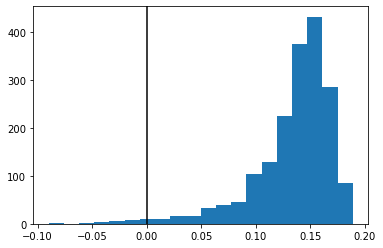

In [82]:
plt.hist(clf.decision_function(df_train_encoded.values), bins=20)
plt.axvline(np.min(clf.decision_function(df_train_encoded.values)[np.where(outliers==1)]), c='k')
plt.show()

In [83]:
outlier_indices = np.where(outliers == -1)[0]
print("Indici degli outlier rilevati:", outlier_indices)

Indici degli outlier rilevati: [  35  240  241  242  243  287  302  554  560  561  563  614 1029 1031
 1283 1757 1758 1759 1801]
